Zadanie 03 - SVM

Piotr Zawiślan

Celem zadania będzie poeksperymentowanie z różnymi ustawieniami klasyfikatora SVM.

In [1]:
import sys
import os
import numpy as np
import sklearn
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from typing import Tuple, Dict, Set, List, Callable, Union
%matplotlib inline

In [2]:
np.random.seed(311)

PLOTS_PATH = os.path.join(".", "plots")
os.makedirs(PLOTS_PATH, exist_ok=True)

In [3]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(PLOTS_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Dane do wykorzystania

Do wykonania zadania potrzebny jest niewielki, dwuwymiarowy zbiór danych. Zależy nam, by
rozkład elementów był nieregularny, z wyspami jednej klasy wewnątrz drugiej.

In [4]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

X, y = make_classification(n_samples=200,
                           n_features=2, 
                           n_redundant=0, 
                           n_informative=2, 
                           random_state=5, 
                           n_clusters_per_class=1,
                           class_sep=0.7)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
X = StandardScaler().fit_transform(X)

lin_sep_dataset = {'X': X, 'y': y}

Saving figure full_dataset


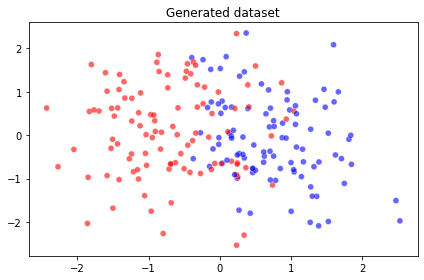

In [5]:
sns.scatterplot(x=lin_sep_dataset['X'][:, 0], 
                y=lin_sep_dataset['X'][:, 1], 
                c=lin_sep_dataset['y'],
                cmap=mpl.colors.ListedColormap(["#FF0000", "#0000FF"]),
                alpha=0.6)
plt.title("Generated dataset")
save_fig('full_dataset')
plt.show()

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1,
                             test_size=0.4, 
                             random_state=99)
for train_index, test_index in sss.split(lin_sep_dataset['X'], lin_sep_dataset['y']):
    X_train, X_test = lin_sep_dataset['X'][train_index], lin_sep_dataset['X'][test_index]
    y_train, y_test = lin_sep_dataset['y'][train_index], y[test_index]
print(f"Train set size: {X_train.shape[0]}")
print(f"Train set ratio: {len(y_train[y_train==1]) / len(y_train)}\n")
print(f"Test set size: {X_test.shape[0]}")
print(f"Test set ratio: {len(y_test[y_test==1]) / len(y_test)}")

Train set size: 120
Train set ratio: 0.49166666666666664

Test set size: 80
Test set ratio: 0.4875


Saving figure train_set


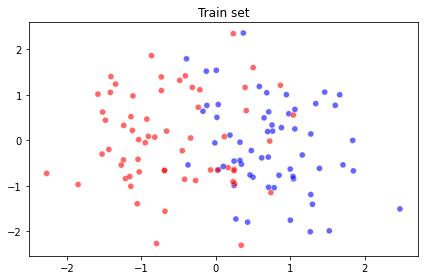

In [7]:
sns.scatterplot(x=X_train[:, 0], 
                y=X_train[:, 1], 
                c=y_train,
                cmap=mpl.colors.ListedColormap(["#FF0000", "#0000FF"]),
                alpha=0.6)
plt.title("Train set")
save_fig('train_set')
plt.show()

Saving figure test_set


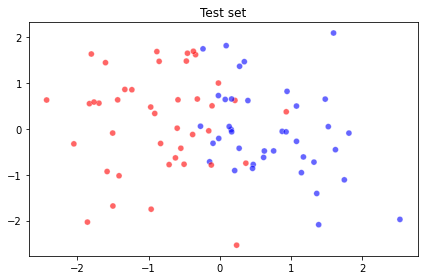

In [8]:
sns.scatterplot(x=X_test[:, 0], 
                y=X_test[:, 1], 
                c=y_test,
                cmap=mpl.colors.ListedColormap(["#FF0000", "#0000FF"]),
                alpha=0.6)
plt.title("Test set")
save_fig('test_set')
plt.show()

# Funkcje wizualizujące

- Granica decyzyjna

Jak wygląda granica decyzyjna - które obszary klasyfikator przypisuje do klasy czerwonej, a które do niebieskiej (i z jakim poziomem pewności). Może się tu mocno przydać kod ze sztandarowego przykładu z biblioteki `scikit-learn`: 
https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html - warto jednak zwiększyć rozdzielczość skali kolorów (by wykrywanych było więcej poziomów).

- Wektory wspierające

Które obserwacje ze zbioru wejściowego zostały wybrane jako wektory wspierające.

- Margines

Jaka jest aktualna szerokość marginesu między klasami (i jej zależność od danego parametru) - przynajmniej dla liniowego SVM.

In [9]:
from sklearn.svm import LinearSVC, SVC

def plot_svc(X_train, X_test, y_train, y_test,
             svm_clf: Union[LinearSVC, SVC], 
             ax=None,
             mesh_h=0.02,
             print_score=True,
             print_margin_width=True,
             custom_kernel=False,
             title=None):
    X = X_train.copy()
    y = y_train.copy()
    
    if ax is None:
        ax = plt.gca()
    
    cm_bright = plt.cm.RdBu
    
    # create meshgrid
    X_full = np.concatenate((X_train, X_test))
    x_min, x_max = X_full[:, 0].min() - 0.5, X_full[:, 0].max() + 0.5
    y_min, y_max = X_full[:, 1].min() - 0.5, X_full[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_h), np.arange(y_min, y_max, mesh_h))
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    
    # train SVM classifier
    svm_clf.fit(X_train, y_train)
    score = svm_clf.score(X_test, y_test)
    if print_score:
        print(f"Test score: {score:.2f}")
    
    # plot decision boundary
    if hasattr(svm_clf, 'decision_function'):
        Z = svm_clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = svm_clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm_bright, alpha=0.8, levels=24)
    
    if hasattr(svm_clf, 'coef_') and hasattr(svm_clf, 'intercept_'):
        w = svm_clf.coef_[0]
        b = svm_clf.intercept_[0]
        
        # plot margin
        x0 = np.arange(x_min, x_max, mesh_h)
        decision_boundary = -w[0] / w[1] * x0 - b / w[1]
        margin = 1  / w[1]
        gutter_up = decision_boundary + margin
        gutter_down = decision_boundary - margin
        ax.plot(x0, decision_boundary, "k-", linewidth=2)
        ax.plot(x0, gutter_up, "k--", linewidth=2)
        ax.plot(x0, gutter_down, "k--", linewidth=2)
        
        if print_margin_width:
            print(f"Margin width: {2 / np.linalg.norm(w):.2f}")
    
    if not custom_kernel:
        if hasattr(svm_clf, 'support_vectors_'):
            # plot support vectors
            svs = svm_clf.support_vectors_
            svs += [-0.013, 0.013]
            ax.scatter(svs[:, 0], svs[:, 1], s=100, facecolors='#50C878', edgecolors="k", alpha=0.5)
        else:
            t = y_train * 2 - 1
            support_vectors_idx = (t * (X_train.dot(w) + b) <= 1).ravel()
            svs = X_train[support_vectors_idx]
            try:
                svs += [-0.013, 0.013]
            except ValueError:
                pass
            ax.scatter(svs[:, 0], svs[:, 1], s=100, facecolors='#50C878', edgecolors="k", alpha=0.5)
    
    # plot dataset
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    ax.scatter(X_test[:, 0],
               X_test[:, 1],
               c=y_test,
               cmap=cm_bright,
               edgecolors="k",
               alpha=0.3)
    
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.text(xx.max() - 0.3,
            yy.min() + 0.3,
            f"{score:.2f}",
            size=15,
            horizontalalignment="right")
    
    if title is not None:
        plt.title(title)


# Testowanie wariantów SVM

In [10]:
from sklearn.svm import LinearSVC, SVC

## "Zwykły" liniowy SVM

- ...z dużym naciskiem na próbki po "właściwej" stronie (wysokie "kary" za nieprawidłowości)...
- ...oraz z dużym naciskiem na regularyzację i szeroki margines (niskie "kary").
- Warto tu sprawdzić wiecej niż dwie wartości parametrów, tylko ich szersze spektrum - w tym opcje "skrajne".

SVC loss: hinge
Test score: 0.89
Margin width: 1.59
Saving figure svc_lin_1


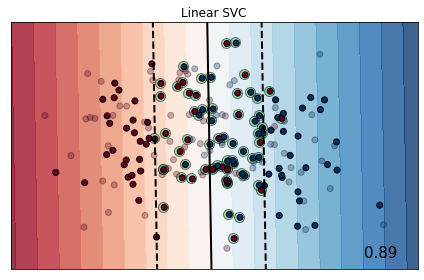

In [48]:
lin_svc = LinearSVC(C=0.1, loss="hinge", random_state=311, max_iter=100000)
print(f"SVC loss: {lin_svc.loss}")
plot_svc(X_train, X_test, y_train, y_test, lin_svc, title="Linear SVC")
save_fig("svc_lin_1")

SVC loss: hinge
Test score: 0.85
Margin width: 1.07
Saving figure svc_lin_2


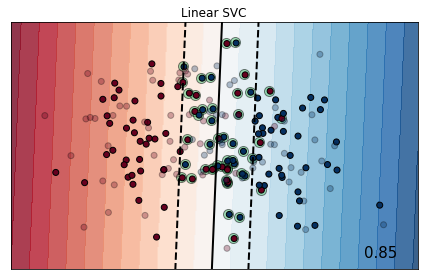

In [49]:
lin_svc = LinearSVC(C=100, loss="hinge", random_state=311, max_iter=100000)
print(f"SVC loss: {lin_svc.loss}")
plot_svc(X_train, X_test, y_train, y_test, lin_svc, title="Linear SVC")
save_fig("svc_lin_2")

SVC loss: hinge
Test score: 0.85
Margin width: 1.07
Saving figure svc_lin_3


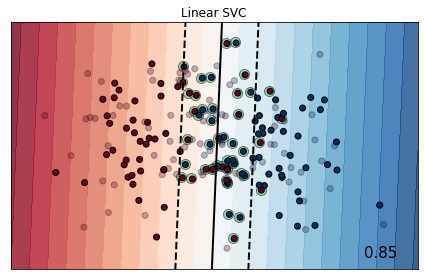

In [50]:
lin_svc = LinearSVC(C=1000000, loss="hinge", random_state=311, max_iter=100000000)
print(f"SVC loss: {lin_svc.loss}")
plot_svc(X_train, X_test, y_train, y_test, lin_svc, title="Linear SVC")
save_fig("svc_lin_3")

SVC loss: hinge
Test score: 0.85
Margin width: 3.12
Saving figure svc_lin_4


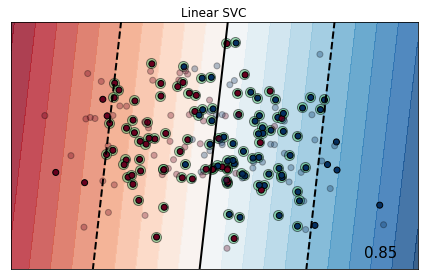

In [51]:
# O(m x n)
lin_svc = LinearSVC(C=0.01, loss="hinge", random_state=311, max_iter=100000)
print(f"SVC loss: {lin_svc.loss}")
plot_svc(X_train, X_test, y_train, y_test, lin_svc, title="Linear SVC")
save_fig("svc_lin_4")

SVC loss: squared_hinge
Test score: 0.86
Margin width: 2.10


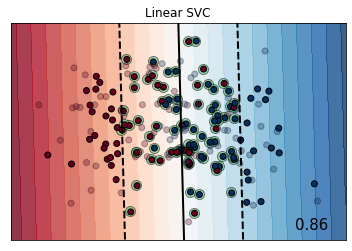

In [31]:
# dual=False ? idk trochę czemu on daje inne wyniki
lin_svc = LinearSVC(C=100000, random_state=311, dual=False)
print(f"SVC loss: {lin_svc.loss}")
plot_svc(X_train, X_test, y_train, y_test, lin_svc, title="Linear SVC")

Test score: 0.86
Margin width: 0.96


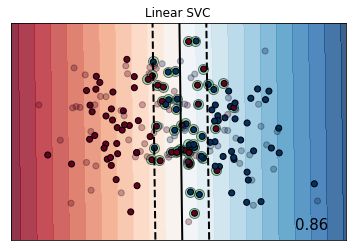

In [39]:
# O(m^2 x n) do O(m^3 x n)
svc = SVC(kernel="linear", C=1000000, random_state=311)
plot_svc(X_train, X_test, y_train, y_test, svc,  title="Linear SVC")

Test score: 0.85
Margin width: 1.07


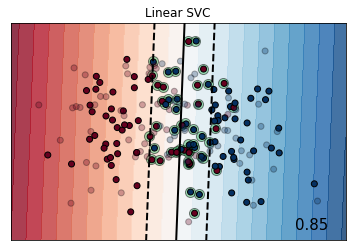

In [32]:
svc = SVC(kernel="linear", C=100, random_state=311)
plot_svc(X_train, X_test, y_train, y_test, svc,  title="Linear SVC")

Test score: 0.89
Margin width: 1.60


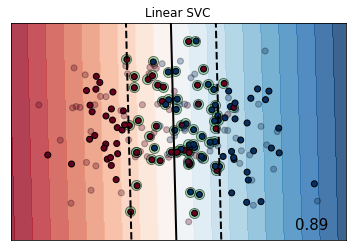

In [33]:
svc = SVC(kernel="linear", C=0.1, random_state=311)
plot_svc(X_train, X_test, y_train, y_test, svc,  title="Linear SVC")

Test score: 0.85
Margin width: 3.19


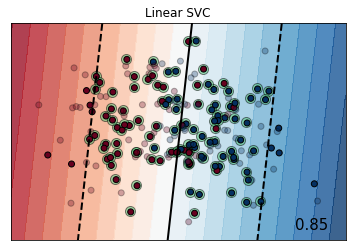

In [38]:
svc = SVC(kernel="linear", C=0.01, random_state=311)
plot_svc(X_train, X_test, y_train, y_test, svc,  title="Linear SVC")

## Kernel SVM - czyli taki z iloczynem skalarnym podmienionym na...

...iloczyn pierwszej składowej obu wektorów, pomijający drugą składową

In [54]:
def kernel_only_first(X, Y):
    return X[:, [0]] @ Y[:, [0]].T

Test score: 0.85
Saving figure svc_ker_of_1


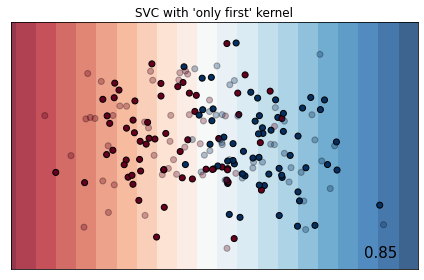

In [58]:
svc = SVC(kernel=kernel_only_first, random_state=311, C=1)
plot_svc(X_train, X_test, y_train, y_test, svc, custom_kernel=True, 
         title="SVC with 'only first' kernel")
save_fig("svc_ker_of_1")

...klasyczny kernel typu RBF (Radial Basis Function)

- Opisuje go wzór taki jak poniżej
$$
    K(x, x') = exp \left( -\frac{||x - x'||^2}{2\sigma^2} \right)
$$

- Jest to funkcja zależna od tytułowego promienia - normy z odległości między wejściowymi wektorami.

- Na jej pracę wpływa też czynnik normalizujący sigma. Warto sprawdzić skutki użycia omawianego kernela dla szerokiego spektrum wartości tego parametru.


Test score: 0.51
Saving figure svc_ker_rbf_1


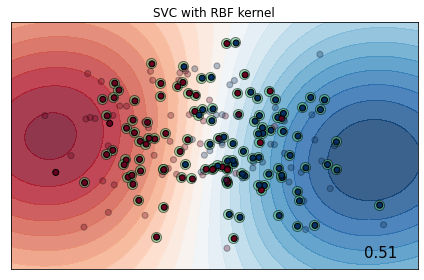

In [59]:
svc = SVC(kernel="rbf", random_state=311, gamma=0.1, C=0.001)
plot_svc(X_train, X_test, y_train, y_test, svc, title="SVC with RBF kernel")
save_fig("svc_ker_rbf_1")

Test score: 0.88
Saving figure svc_ker_rbf_2


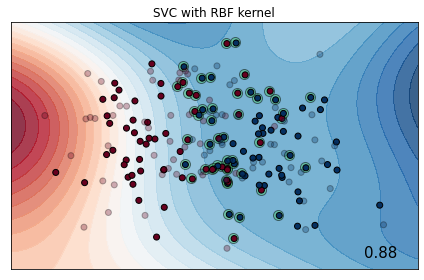

In [60]:
svc = SVC(kernel="rbf", random_state=311, gamma=0.1, C=1000)
plot_svc(X_train, X_test, y_train, y_test, svc, title="SVC with RBF kernel")
save_fig("svc_ker_rbf_2")

Test score: 0.51
Saving figure svc_ker_rbf_3


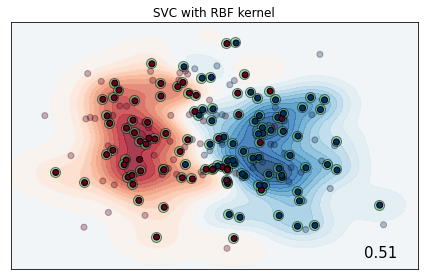

In [61]:
svc = SVC(kernel="rbf", random_state=311, gamma=5, C=0.001)
plot_svc(X_train, X_test, y_train, y_test, svc, title="SVC with RBF kernel")
save_fig("svc_ker_rbf_3")

Test score: 0.74
Saving figure svc_ker_rbf_4


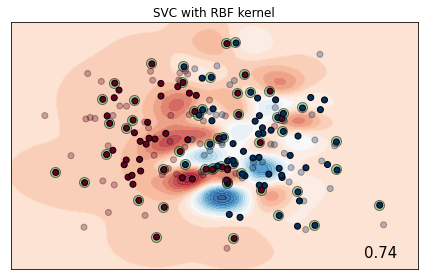

In [62]:
svc = SVC(kernel="rbf", random_state=311, gamma=5, C=1000)
plot_svc(X_train, X_test, y_train, y_test, svc, title="SVC with RBF kernel")
save_fig("svc_ker_rbf_4")

..."kanciasty" kernel typu RBF: funkcję, która zwraca 1 jeżeli wektory są odległe o
mniej niż pewna ustalona minimalna odległość R ("leżą koło siebie") i 0 w
przeciwnym wypadku ("nie leżą w pobliżu")

- Podobnie jak w przypadku wspomnianego w poprzednim punkcie paremetru sigma - warto zbadać zachowanie dla różnych wartości R, dobierając rozważany ich zakres w zależności od typowych odległości w zbiorze danych.

In [63]:
R = 1
def kernel_angular(X, Y):
    global R
    gram_matrix = np.zeros((X.shape[0], Y.shape[0]))
    for i, x in enumerate(X):
        x_flat = x.flatten()
        for j, y in enumerate(Y):
            y_flat = y.flatten()
            gram_matrix[i, j] = 1. if np.linalg.norm(x_flat - y_flat) < R else 0.
    return gram_matrix

Test score: 0.71
Saving figure svc_ker_ang_1


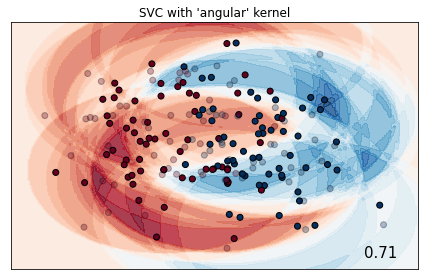

In [64]:
R = 2
svc = SVC(kernel=kernel_angular, random_state=311, C=1)
plot_svc(X_train, X_test, y_train, y_test, svc, 
         title="SVC with 'angular' kernel", custom_kernel=True)
save_fig("svc_ker_ang_1")

Test score: 0.74
Saving figure svc_ker_ang_2


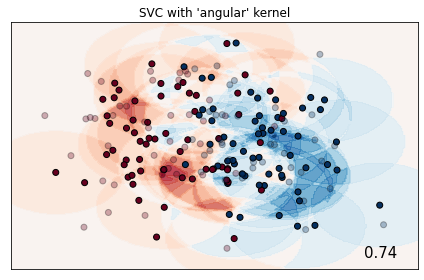

In [65]:
R = 1
svc = SVC(kernel=kernel_angular, random_state=311, C=1)
plot_svc(X_train, X_test, y_train, y_test, svc, 
         title="SVC with 'angular' kernel", custom_kernel=True)
save_fig("svc_ker_ang_2")

Test score: 0.76
Saving figure svc_ker_ang_3


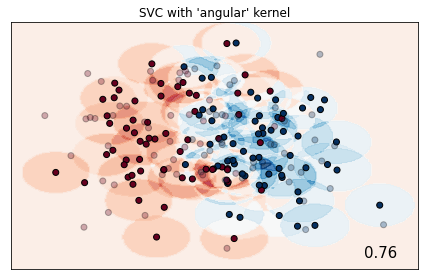

In [66]:
R = 0.5
svc = SVC(kernel=kernel_angular, random_state=311, C=1)
plot_svc(X_train, X_test, y_train, y_test, svc, 
         title="SVC with 'angular' kernel", custom_kernel=True)
save_fig("svc_ker_ang_3")

Test score: 0.64
Saving figure svc_ker_ang_4


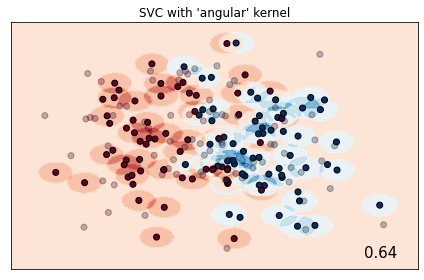

In [67]:
R = 0.25
svc = SVC(kernel=kernel_angular, random_state=311, C=1)
plot_svc(X_train, X_test, y_train, y_test, svc, 
         title="SVC with 'angular' kernel", custom_kernel=True)
save_fig("svc_ker_ang_4")

..."częściwo liniowy" kernel typu RBF: funkcję, która poniżej pewnej minimalnej
odległości R zwraca (R - odległość)/R - a dla mniejszych zwraca po prostu 0;

In [68]:
R = 1
def kernel_partially_linear(X, Y):
    global R
    gram_matrix = np.zeros((X.shape[0], Y.shape[0]))
    for i, x in enumerate(X):
        x_flat = x.flatten()
        for j, y in enumerate(Y):
            y_flat = y.flatten()
            distance = np.linalg.norm(x_flat - y_flat)
            gram_matrix[i, j] = (R - distance) / R if distance < R else 0.
    return gram_matrix

Test score: 0.85
Saving figure svc_ker_pl_1


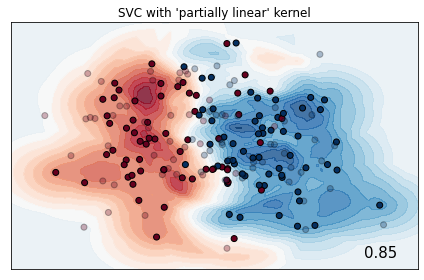

In [70]:
R = 1
svc = SVC(kernel=kernel_partially_linear, random_state=311, C=1)
plot_svc(X_train, X_test, y_train, y_test, svc, 
         title="SVC with 'partially linear' kernel", custom_kernel=True)
save_fig("svc_ker_pl_1")

Test score: 0.80
Saving figure svc_ker_pl_2


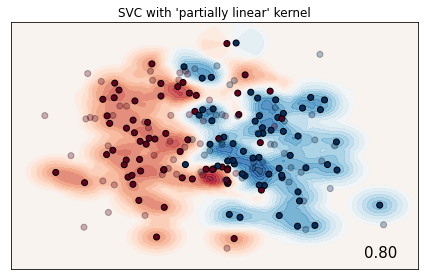

In [78]:
R = 0.5
svc = SVC(kernel=kernel_partially_linear, random_state=311, C=1)
plot_svc(X_train, X_test, y_train, y_test, svc, 
         title="SVC with 'partially linear' kernel", custom_kernel=True)
save_fig("svc_ker_pl_2")

...kernel zależny od kąta między wektorami prowadzącymi od punktu leżącego w
centrum zbioru danych do poszczególnych obserwacji ("wskazówek zegara").

In [72]:
train_center = X_train.mean(axis=0)
def kernel_angle_from_center(X, Y):
    global train_center
    gram_matrix = np.zeros((X.shape[0], Y.shape[0]))
    for i, x in enumerate(X):
        x_flat = x.flatten()
        for j, y in enumerate(Y):
            y_flat = y.flatten()
            gram_matrix[i, j] = \
                np.dot(x_flat, y_flat) / (np.linalg.norm(x_flat) * np.linalg.norm(y_flat))
    return gram_matrix

Test score: 0.84
Saving figure svc_ker_ac_1


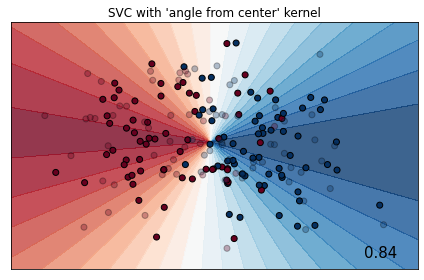

In [79]:
svc = SVC(kernel=kernel_angle_from_center, random_state=311, C=100)
plot_svc(X_train, X_test, y_train, y_test, svc, 
         title="SVC with 'angle from center' kernel", custom_kernel=True)
save_fig("svc_ker_ac_1")

Test score: 0.88
Saving figure svc_ker_ac_2


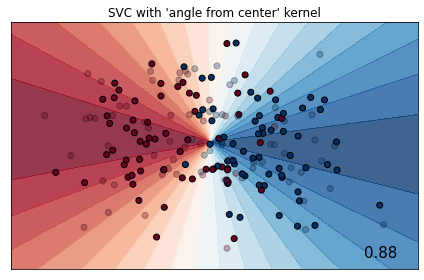

In [80]:
svc = SVC(kernel=kernel_angle_from_center, random_state=311, C=0.1)
plot_svc(X_train, X_test, y_train, y_test, svc, 
         title="SVC with 'angle from center' kernel", custom_kernel=True)
save_fig("svc_ker_ac_2")

Dla każdego z tych wariantów obserwujemy jak "pokolorowana" jest przestrzeń
decyzyjna - jak zmiana parametrów (lub podmiana iloczynu skalarnego) wpłynęła na
rezultaty.